## **Preparing data for Machine learning**

### **Goal**:
You are the data scientist assigned to perform the data pre-processing and preparing the data for Machine Learning algorithms.

1. Perform data exploration to understand the data
2. Prepare the test and training sets.
3. Pre-processing of the data, including fixing all the missing values (set the missing values to median values) and any other ones that you think are appropriate to perform. Build a pipeline to perform data transformation. (5 points)

In the next hands-on, we will use 14 out of 15 attributes as pedictors describe below to predict if income goes above or below \$50K/yr based on census data. `Income` will be the label.

Dataset is from [UCI](https://archive.ics.uci.edu/dataset/2/adult)

### Data:
An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.

### Fields:
The dataset contains 15 columns

#### Target field: Income
- The income is divide into two classes: 50K

#### Number of attributes: 14
-- These are the demographics and other features to describe a person

We can explore the possibility in predicting income level based on the individual’s personal information

- `age`: continuous.
- `workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- `fnlwgt`: continuous.
- `education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- `education-num`: continuous.
- `marital-status`: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- `occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- `relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- `race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- `sex`: Female, Male.
- `capital-gain`: continuous.
- `capital-loss`: continuous.
- `hours-per-week`: continuous.
- `native-country`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- `salary`: >50K,<=50K

Note: "?" is used to represent missing data in this dataset.

In [25]:
import warnings

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    average_precision_score,
)


# Read in data. Consider that "?" is used in place of na
adults_fp = 'https://raw.githubusercontent.com/csbfx/advpy122-data/master/adult.csv'


## Part 1: Data Exploration
Let's examine the data. What are some ways to look at the different attribute in the dataframe? What are some good way to quickly get a feel of the type of data you are dealing with? Examples we have used in class includes looking at relationship/correlation and histograms.

In [26]:
adults = pd.read_csv(adults_fp)
print(adults.shape)
adults.head()


(48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Part 2: Prepare Training & Testing data sets
We next want to create a test set. Set aside 20% of the dataset. To reduce the risk of sampling bias, consider using stratified sampling. For example consider the `income` where we create 5 stratas ranging from \$0 to \$15,000 (take a look at the income data and consider how to bin to reflect the income in \$USD).

In [27]:
X = adults.drop("income", axis=1)
y = adults["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nIncome distribution in train set:")
print(y_train.value_counts(normalize=True))
print("\nIncome distribution in test set:")
print(y_test.value_counts(normalize=True))


Train shape: (39073, 14)
Test shape: (9769, 14)

Income distribution in train set:
income
<=50K    0.76073
>50K     0.23927
Name: proportion, dtype: float64

Income distribution in test set:
income
<=50K    0.760672
>50K     0.239328
Name: proportion, dtype: float64


## Part 3: Pre-processing data

Once we have our training and testing dataset, clean up your dataframe if there are redundant attributes or features that would not be useful in machine learning models such as unique identifiers.

In [28]:
# 1. Replace '?' with NaN
X_train_clean = X_train.replace('?', np.nan)
X_test_clean = X_test.replace('?', np.nan)

# Identify numeric and categorical columns
numeric_cols = X_train_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train_clean.select_dtypes(include=['object']).columns

In [29]:
# 2. Preprocessing for numeric features: median imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# 3. Preprocessing for categorical features: most_frequent + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [30]:
# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Fit the preprocessing pipeline on training data
preprocessor.fit(X_train_clean)

# Transform both train/test
X_train_processed = preprocessor.transform(X_train_clean)
X_test_processed = preprocessor.transform(X_test_clean)

print("Train processed shape:", X_train_processed.shape)
print("Test processed shape:", X_test_processed.shape)

Train processed shape: (39073, 105)
Test processed shape: (9769, 105)


It is a good idea to further investigate your attributes by using correlation matrix and Seaborn pairplot to understand how different attributes are related.

**Feature engineering**-   
It is useful for ML algorithms to prepare data in meaningful ways. For example, it could be useful to look at the total number of rooms relative to each household. Similarly, the total number of bedrooms is not as meaninful as the number of bedrooms relative to the total number of rooms. Another interesting attribute could be the population per household

## Part 4: ML models
Select two ML Model to make prediction on housing price. Explain why you selected these two models. Perform 10-fold Cross Validation.

In [31]:
# Ignore convergence warnings from logistic regression to keep the output clean
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Two models: a simple linear model and a more complex tree-based model
log_reg = LogisticRegression(
    max_iter=2000,
    solver="liblinear",
    n_jobs=-1
)

rf_clf = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf
}

In [32]:
# 10-fold stratified cross-validation on the training data
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train_processed,
        y_train,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    print(f"{name} 10-fold CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression 10-fold CV accuracy: 0.7984 ± 0.0035
Random Forest 10-fold CV accuracy: 0.8508 ± 0.0061


In [33]:
# Train the Random Forest model on the full training data

rf_clf.fit(X_train_processed, y_train)
y_pred = rf_clf.predict(X_test_processed)
test_acc = accuracy_score(y_test, y_pred)
print("\nRandom Forest test accuracy:", round(test_acc, 4))


Random Forest test accuracy: 0.8578


## Part 5: Fine-tune your model
Pick the best model from Part 4 and perform fine-tuning. Use the fine-tuned model and evaluate its performance using the test set. How does the fine tune compared to your original evaluation in Part 4.

In [34]:
# Base model from Part 4
rf_base = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)



In [35]:
# Parameter search space (small & fast for homework)
param_dist = {
    "n_estimators": randint(50, 150),
    "max_depth": randint(3, 15),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

# Randomized search (fast)
search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,            # try 10 random combinations
    cv=5,                 # 5-fold CV
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

In [36]:
# Run tuning
search.fit(X_train_processed, y_train)

print("Best parameters:", search.best_params_)
print("Best CV accuracy:", round(search.best_score_, 4))

# Evaluate tuned model on test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test_processed)
test_acc = accuracy_score(y_test, y_pred)
print("Fine-tuned model test accuracy:", round(test_acc, 4))

Best parameters: {'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 149}
Best CV accuracy: 0.8601
Fine-tuned model test accuracy: 0.8622


## Bonus: Evaluating the model using the Confusion Matrix and a Precision-Recall Curve
A confusion matrix is a tabular summary of the number of correct and incorrect predictions made by a classifier. It can be used to evaluate the performance of a classification model through the calculation of performance metrics such as [accuracy, precision, recall, and F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html). Here is [an article](https://medium.com/swlh/explaining-accuracy-precision-recall-and-f1-score-f29d370caaa8) that gives a good explaination of Precision, Recall, and F1-score.

#### **Accuracy**
   
Accuracy = $\frac{True\ Positives\ +\ True\ Negatives}{All\ Samples}$

**Precision (aka Specificity)**

Precision = $\frac{True\ Positives}{True\ Positives\ +\ False\ Positives}$
= $\frac{True\ Positives}{Total\ Predicted\ Positives}$


**Recall (aka Sensitivity)**

Recall = $\frac{True\ Positives}{True\ Positives\ +\ False\ Negatives}$
= $\frac{True\ Positives}{Total\ Actual\ Positives}$

**F1-score (combining Precision and Recall)**

F1-score = $\frac{2\ ×\ (Precision\ ×\ Recall)}{Precision\ +\ Recall}$

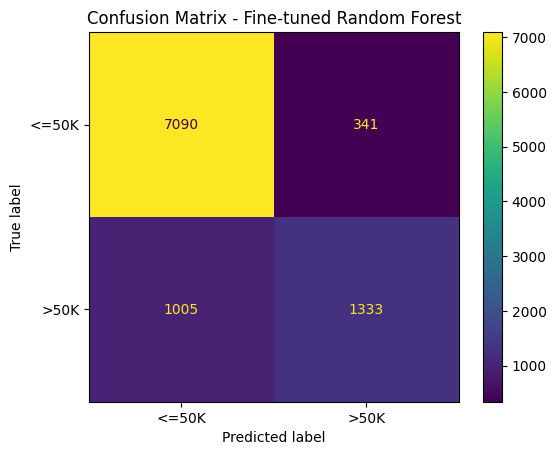

In [37]:
# 1. Predictions from the fine-tuned model
y_pred = best_model.predict(X_test_processed)

# 2. Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["<=50K", ">50K"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["<=50K", ">50K"])
disp.plot()
plt.title("Confusion Matrix - Fine-tuned Random Forest")
plt.show()


In [38]:
# 3. Accuracy, Precision, Recall, F1-score (per class + overall)
print("Classification report (accuracy, precision, recall, F1):")
print(classification_report(y_test, y_pred, digits=4))

# 4. Precision–Recall curve for the positive class (>50K)
#    Get predicted probabilities for the positive class
proba = best_model.predict_proba(X_test_processed)
pos_idx = list(best_model.classes_).index(">50K")
y_scores = proba[:, pos_idx]

precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_scores,
    pos_label=">50K"
)
ap = average_precision_score(y_test, y_scores, pos_label=">50K")

Classification report (accuracy, precision, recall, F1):
              precision    recall  f1-score   support

       <=50K     0.8758    0.9541    0.9133      7431
        >50K     0.7963    0.5701    0.6645      2338

    accuracy                         0.8622      9769
   macro avg     0.8361    0.7621    0.7889      9769
weighted avg     0.8568    0.8622    0.8538      9769



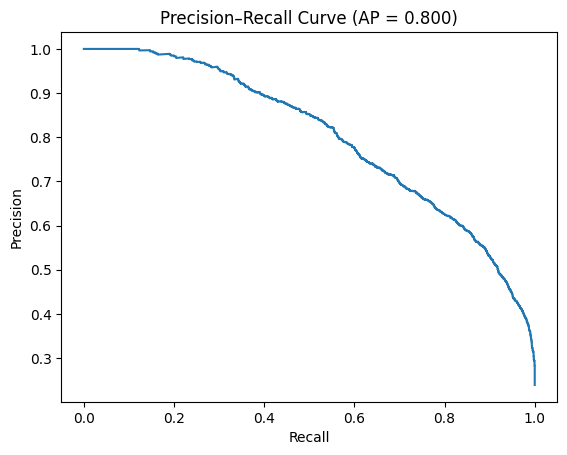

In [39]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.show()

#### **Precision-Recall Curve**
[Precision-Recall Curve documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)


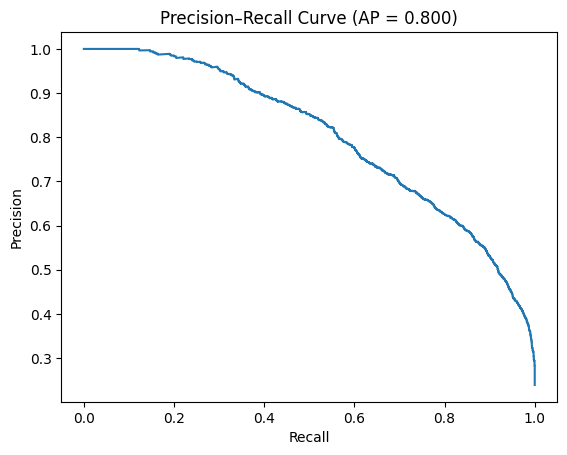

In [40]:
# Convert y_test to binary labels
y_test_binary = (y_test == ">50K").astype(int)

# Get predicted probabilities for ">50K"
proba = best_model.predict_proba(X_test_processed)
pos_idx = list(best_model.classes_).index(">50K")
y_scores = proba[:, pos_idx]

# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_scores)
ap = average_precision_score(y_test_binary, y_scores)

# Plot
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.show()